In [52]:
import matplotlib.pyplot as plt
import pandas as pd
import sys
import scipy
import scipy.stats as stats
import numpy as np
import pickle

# GCP

In [19]:
fGCB = './../../Prelim_Data_Analysis/gcb_data/budget.csv'
df = pd.read_csv(fGCB,
                 index_col=0,
                 usecols=[0,4,5,6])
df.head()

,ocean sink,land sink,budget imbalance
Year,,,
1959,0.852376,0.516073,0.860316
1960,0.819017,1.394030,0.522722
1961,0.714842,0.605098,1.213762
1962,0.756709,1.348349,0.959605
1963,0.904997,0.877794,1.355333


In [20]:
fCO2 = './../co2_temp_data/co2_global.csv'
CO2 = pd.read_csv(fCO2, index_col=0)[2:]
CO2.head()

,CO2
Year,
1959,315.486
1960,316.163
1961,316.856
1962,317.558
1963,318.268


In [21]:
df['CO2'] = CO2
df['land sink'] = -df['land sink']
df['ocean sink'] = -df['ocean sink']
df['budget imbalance'] = -df["budget imbalance"]+df['land sink']

df.head()

,ocean sink,land sink,budget imbalance,CO2
Year,,,,
1959,-0.852376,-0.516073,-1.376389,315.486
1960,-0.819017,-1.394030,-1.916752,316.163
1961,-0.714842,-0.605098,-1.818860,316.856
1962,-0.756709,-1.348349,-2.307954,317.558
1963,-0.904997,-0.877794,-2.233127,318.268


In [22]:
df.rename(columns={"ocean sink": "ocean", "land sink": "land model", "budget imbalance": "land"},
         inplace=True)
df.head()

,ocean,land model,land,CO2
Year,,,,
1959,-0.852376,-0.516073,-1.376389,315.486
1960,-0.819017,-1.394030,-1.916752,316.163
1961,-0.714842,-0.605098,-1.818860,316.856
1962,-0.756709,-1.348349,-2.307954,317.558
1963,-0.904997,-0.877794,-2.233127,318.268


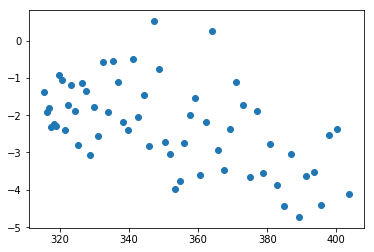

In [23]:
plt.scatter(df.CO2, df['land'])

In [24]:
def rolling_trend(data, sink='land', window=10, r_plot=False):
    
    data = data[['CO2', sink]]
    
    roll_values = []
    r_values = []
    
    for i in range(0,59-window):
        df = data.iloc[i:i+window+1]
        stats_info = stats.linregress(df['CO2'], df[sink])
        roll_values.append(stats_info[0])
        r_values.append(stats_info[2])
        
    data.plot(x='CO2', y=sink)
    plt.ylabel('C flux to the atmosphere (GtC)')
    
    roll_df = pd.DataFrame({f'{window}-year trend slope': roll_values}, index=data.index[:-window])
    roll_df.plot(color='g')
    plt.ylabel('Slope of C flux trend (GtC/ppm/yr)')
    
    if r_plot:
        r_df = pd.DataFrame({'r-values of trends': r_values}, index=data.index[:-window])
        r_df.plot(color='k')
        plt.ylabel('r-value of slope')
        return roll_df, r_df
    
    return roll_df

In [26]:
p=df[['CO2', 'land']].iloc[0+30:11+30]
stats.linregress(p['CO2'], p['land'])

LinregressResult(slope=0.11382986820008272, intercept=-43.288716377728754, rvalue=0.4786130827447902, pvalue=0.1364149829266733, stderr=0.06960777463549518)

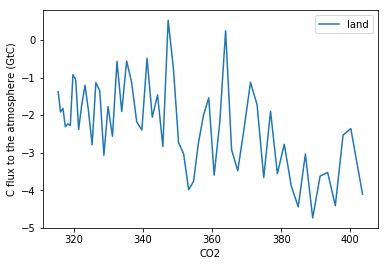

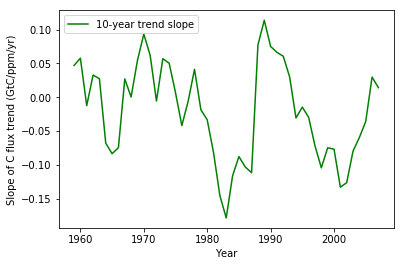

In [27]:
land_10_co2=rolling_trend(df, sink='land', window=10)

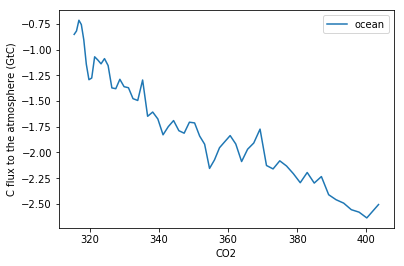

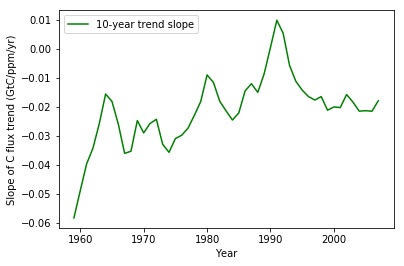

In [28]:
ocean_10_co2=rolling_trend(df, sink='ocean', window=10)

In [29]:
stats.linregress(land_10_co2.index, land_10_co2.values.squeeze())

LinregressResult(slope=-0.0014661561685334172, intercept=2.8874518349522136, rvalue=-0.29330281643013373, pvalue=0.040821053189736334, stderr=0.0006970787786070104)

In [30]:
stats.linregress(ocean_10_co2.index, ocean_10_co2.values.squeeze())

LinregressResult(slope=0.000495604614004773, intercept=-1.0039156907116498, rvalue=0.584013749971374, pvalue=1.0570682001171836e-05, stderr=0.0001004806188519783)

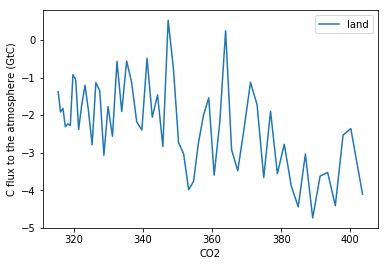

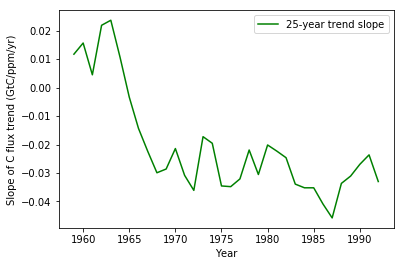

In [31]:
land_25_co2=rolling_trend(df, sink='land', window=25)

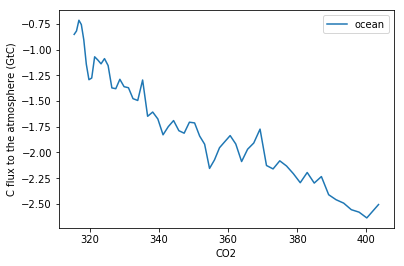

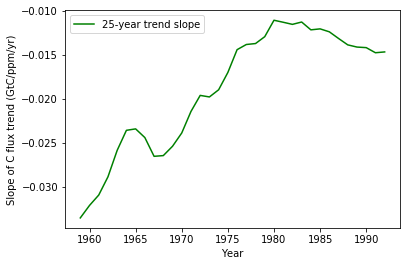

In [32]:
ocean_25_co2=rolling_trend(df, sink='ocean', window=25)

In [34]:
stats.linregress(land_25_co2.index, land_25_co2.values.squeeze())

LinregressResult(slope=-0.0013935397351286796, intercept=2.732463304227662, rvalue=-0.7474973112397009, pvalue=3.7817621940425956e-07, stderr=0.00021891523888190455)

In [33]:
stats.linregress(ocean_25_co2.index, ocean_25_co2.values.squeeze())

LinregressResult(slope=0.0006159595886242523, intercept=-1.2357138562635652, rvalue=0.891509216718999, pvalue=1.5410840293732682e-12, stderr=5.5328901389972974e-05)

# Non-linear regression fits

In [48]:
def plot_df_var(df, x="CO2", y="land"):
    plt.plot(df[x], df[y])
    
    xlabel=x
    if x=="CO2":
        xlabel=x+" (ppm)"
    plt.xlabel(xlabel)
    
    plt.ylabel("C flux to the atmosphere (GtC/yr)")
    plt.title(y)

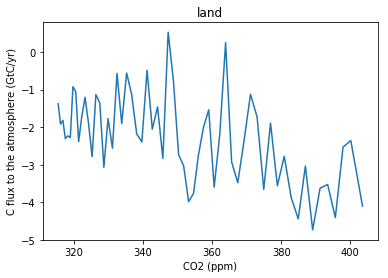

In [49]:
plot_df_var(df)

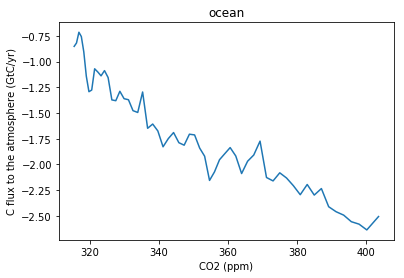

In [51]:
plot_df_var(df, y='ocean')

In [55]:
def func(x, a, b, c):
    return a*(x**2)+b*x+c

In [64]:
popt_ocean, pcov_ocean = scipy.optimize.curve_fit(func, df['CO2'], df['ocean']) 
popt_ocean

array([ 1.26842926e-04, -1.08948555e-01,  2.08068509e+01])

In [96]:
lin_ocean = stats.linregress(df['CO2'], df['ocean'])
lin_ocean

LinregressResult(slope=-0.018663021300575892, intercept=4.828183567608177, rvalue=-0.9568089678775581, pvalue=2.8737105933174943e-32, stderr=0.0007510870825902207)

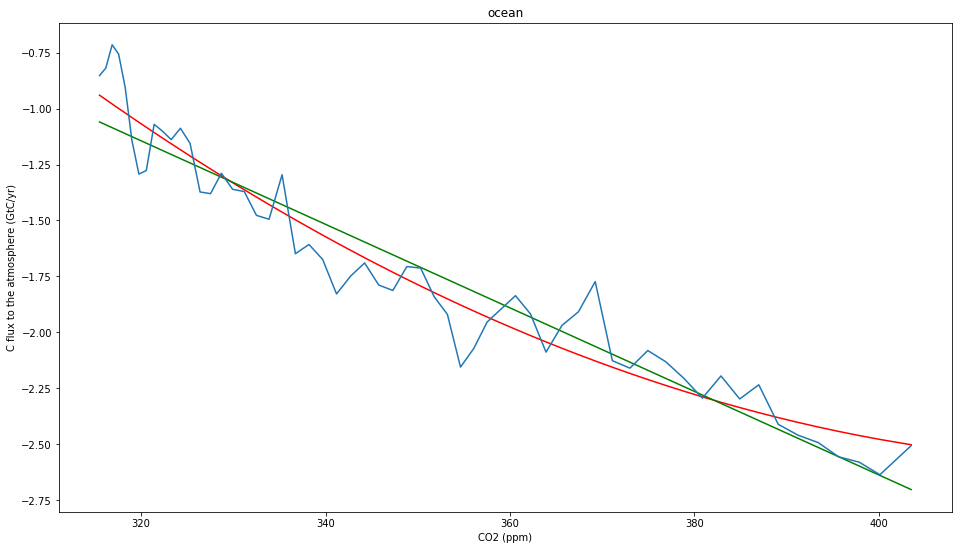

In [98]:
plt.figure(figsize=(16,9))
plt.plot(df['CO2'], func(df['CO2'], *popt_ocean), 'r-')
plt.plot(df['CO2'], lin_ocean[0]*df['CO2']+lin_ocean[1], 'g-')
plot_df_var(df, y='ocean')

In [70]:
acc_ocean=popt_ocean[0]*2; acc_ocean

0.00025368585157642637

In [72]:
popt_land, pcov_land = scipy.optimize.curve_fit(func, df['CO2'], df['land']) 
popt_land

array([-3.12697113e-04,  1.98644395e-01, -3.32670453e+01])

In [99]:
lin_land = stats.linregress(df['CO2'], df['land'])
lin_land

LinregressResult(slope=-0.02393030060522134, intercept=6.124060670997264, rvalue=-0.5358735325843047, pvalue=1.2206527776897004e-05, stderr=0.00499395143773334)

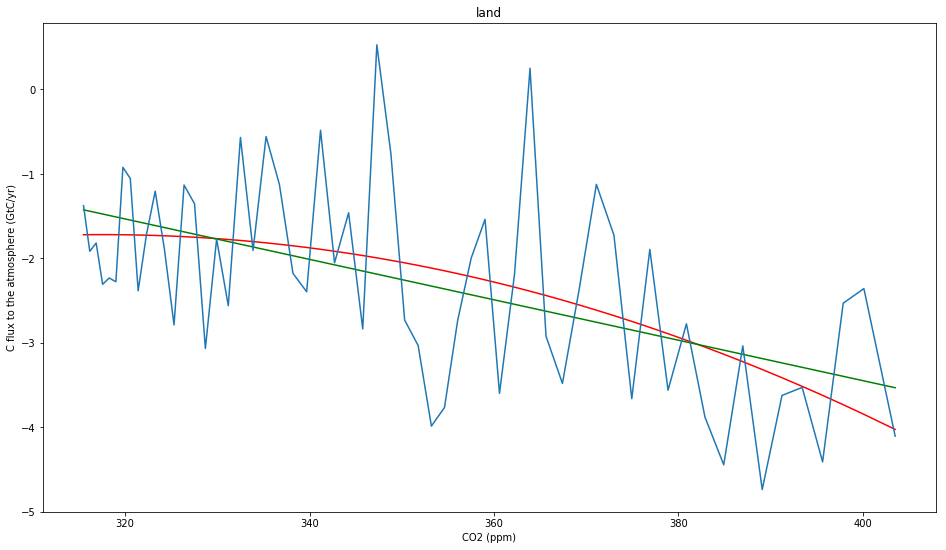

In [100]:
plt.figure(figsize=(16,9))
plt.plot(df['CO2'], func(df['CO2'], *popt_land), 'r-')
plt.plot(df['CO2'], lin_land[0]*df['CO2']+lin_land[1], 'g-')
plot_df_var(df, y='land')

In [74]:
acc_land=popt_land[0]*2; acc_land

-0.0006253942254680422